## Neural network predicting 5 points at once based on velocities

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.getcwd()) + '/OpenTraj/opentraj/') # Anaconda python can't find the toolkit path without this for some reason

from toolkit.loaders.loader_edinburgh import load_edinburgh
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
# tensorflow logging level
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Data preparation

In [3]:
opentraj_root = './OpenTraj/'
selected_day = '01Sep' # 3 days of data in total, ['01Jul', '01Aug', '01Sep']
edinburgh_path = os.path.join(opentraj_root, 'datasets/Edinburgh/annotations', 'tracks.%s.txt' % selected_day)
traj_dataset = load_edinburgh(edinburgh_path, title="Edinburgh", 
                              use_kalman=False, scene_id=selected_day, sampling_rate=9)

reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:01<00:00, 37.78it/s]


Warning! too big dt in [Edinburgh]
finish


In [22]:
data = traj_dataset.data
NUM_OF_STEPS = 5

# Removing any agents which don't have enough steps for model fitting and predicting
agent_ids = data.agent_id.unique()
for agent_id in agent_ids:
    if len(data[data.agent_id == agent_id]) < 2*NUM_OF_STEPS:
        data = data[data.agent_id != agent_id]
agent_ids = data.agent_id.unique()

In [23]:
# 'Normalize' the data so that all trajectories will begin at x=0, y=0
for agent_id in agent_ids:
    first_x = data[data.agent_id == agent_id]['pos_x'].iloc[0]
    first_y = data[data.agent_id == agent_id]['pos_y'].iloc[0]
    
    data.loc[data.agent_id == agent_id, 'pos_x'] = data[data.agent_id == agent_id]['pos_x'] - first_x
    data.loc[data.agent_id == agent_id, 'pos_y'] = data[data.agent_id == agent_id]['pos_y'] - first_y

In [24]:
# Select the useful columns from the dataset
data = data[['index', 'agent_id', 'pos_x', 'pos_y', 'vel_x', 'vel_y']]

In [25]:
from sklearn.model_selection import train_test_split
train_agent_ids, test_agent_ids = train_test_split(agent_ids, test_size=0.2)

### Helper functions

In [26]:
def create_dataset(data, agent_ids):
    data_X, data_Y_vel_x, data_Y_vel_y = [], [], []
    for agent_id in agent_ids:
        # We only see 4 velocities, so train is 4 velocities long
        x = data[data['agent_id'] == agent_id].iloc[1:5][['vel_x', 'vel_y']]
        y_vel_x = data[data['agent_id'] == agent_id].iloc[5:10]['vel_x']
        y_vel_y = data[data['agent_id'] == agent_id].iloc[5:10]['vel_y']
        data_X.append(x)
        data_Y_vel_x.append(y_vel_x)
        data_Y_vel_y.append(y_vel_y)
    return np.array(data_X), np.array(data_Y_vel_x), np.array(data_Y_vel_y)
    
def calculate_error(pred_x, pred_y, test_x, test_y):
    
    # FDE
    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    # MSE
    abs_error_x = pred_x - test_x
    abs_error_y = pred_y - test_y
    
    MSE = np.mean(np.square(abs_error_x)) + np.mean(np.square(abs_error_y))
    
    return FDE, MSE

## Experiment

In [27]:
train = create_dataset(data, train_agent_ids)
test = create_dataset(data, test_agent_ids)

In [28]:
from keras.models import Model
from keras.layers import *
from keras import backend as K

# Note: RMSE seems to yield a worse loss than mean_squared_error
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
def RMSE_with_discount(y_true, y_pred):
    difference = y_true - y_pred
    difference = difference * [1, 0.95, 0.90, 0.85, 0.80]
    return K.sqrt(K.mean(K.square(difference))) 
    

#inp = Input((5,2))
inp = Input((4,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

'''
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
'''
out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

model = Model(inputs=inp, outputs=[out1,out2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = RMSE)

In [29]:
y_vel_x, y_vel_y = train[1], train[2] # separate the y data into x and y position columns
model.fit(train[0], [y_vel_x, y_vel_y], epochs=400, batch_size=32, verbose=2)

Epoch 1/400


2022-01-13 16:54:14.015461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 - 1s - loss: 1.5478 - dense_10_loss: 0.7170 - dense_11_loss: 0.8308 - 528ms/epoch - 26ms/step
Epoch 2/400
20/20 - 0s - loss: 1.3491 - dense_10_loss: 0.6208 - dense_11_loss: 0.7283 - 111ms/epoch - 6ms/step
Epoch 3/400
20/20 - 0s - loss: 1.1716 - dense_10_loss: 0.5338 - dense_11_loss: 0.6377 - 108ms/epoch - 5ms/step
Epoch 4/400
20/20 - 0s - loss: 1.0744 - dense_10_loss: 0.4928 - dense_11_loss: 0.5816 - 104ms/epoch - 5ms/step
Epoch 5/400
20/20 - 0s - loss: 1.0263 - dense_10_loss: 0.4704 - dense_11_loss: 0.5559 - 102ms/epoch - 5ms/step
Epoch 6/400
20/20 - 0s - loss: 0.9892 - dense_10_loss: 0.4530 - dense_11_loss: 0.5362 - 104ms/epoch - 5ms/step
Epoch 7/400
20/20 - 0s - loss: 0.9529 - dense_10_loss: 0.4525 - dense_11_loss: 0.5004 - 110ms/epoch - 6ms/step
Epoch 8/400
20/20 - 0s - loss: 0.9183 - dense_10_loss: 0.4271 - dense_11_loss: 0.4912 - 103ms/epoch - 5ms/step
Epoch 9/400
20/20 - 0s - loss: 0.8877 - dense_10_loss: 0.4064 - dense_11_loss: 0.4814 - 106ms/epoch - 5ms/step
Epoch 10/400

In [30]:
trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
print('Train Score: %.2f' % (trainScore[0]))

testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
print('Test Score: %.2f' % (testScore[0]))

Train Score: 0.50


2022-01-13 16:54:58.175232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test Score: 0.98


## Making predictions on test data

2022-01-13 16:55:01.835168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


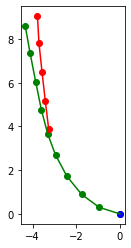

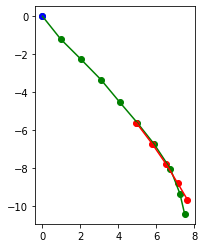

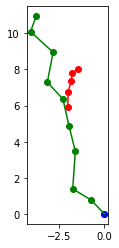

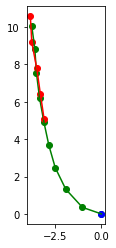

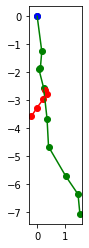

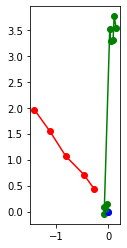

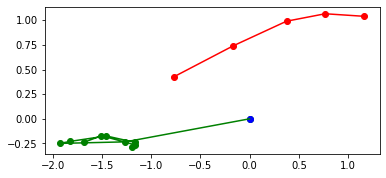

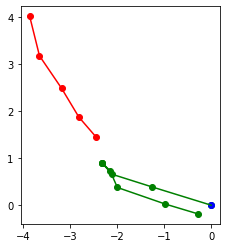

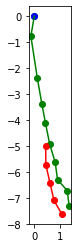

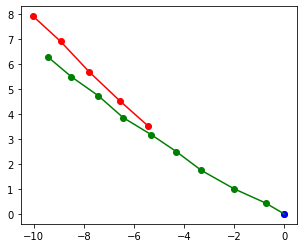

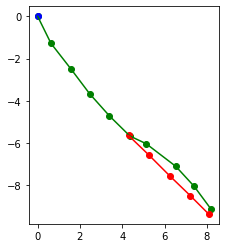

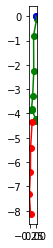

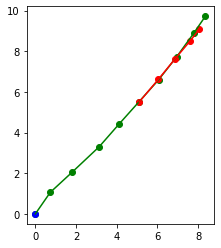

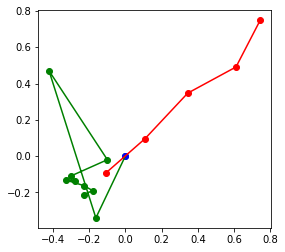

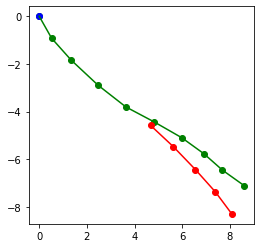

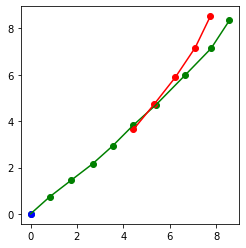

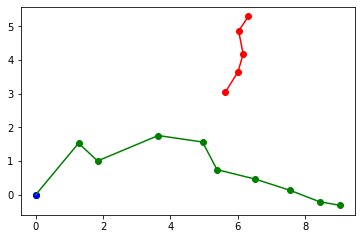

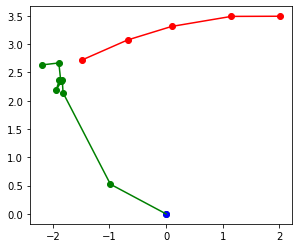

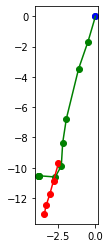

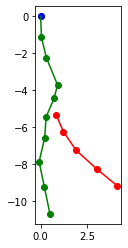

Average FDE:  2.238791467939892


In [31]:
all_FDE = []
plotting = True
no_of_plotted_trajectories = 20

for idx, agent_id in enumerate(test_agent_ids):

    seen_x = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_x'])
    seen_y = np.array(data[data['agent_id'] == agent_id].iloc[:5]['pos_y'])
    
    seen_vel_x = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_x'])
    seen_vel_y = np.array(data[data['agent_id'] == agent_id].iloc[1:5]['vel_y'])
    
    unseen_x = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_x'])
    unseen_y = np.array(data[data['agent_id'] == agent_id].iloc[5:10]['pos_y'])

    pred_vel_x, pred_vel_y = model.predict(np.array([np.column_stack((seen_vel_x, seen_vel_y))]))
    pred_vel_x = pred_vel_x[0] # destructure the prediction array as it is [[x1, x2, x3...]]
    pred_vel_y = pred_vel_y[0]
    
    pred_coord_x = [seen_x[-1] + pred_vel_x[0]]
    pred_coord_y = [seen_y[-1] + pred_vel_y[0]]
    
    for i in range(1, 5):
        pred_coord_x.append(pred_coord_x[-1] + pred_vel_x[i])
        pred_coord_y.append(pred_coord_y[-1] + pred_vel_y[i])

    FDE = np.sqrt((pred_coord_x[-1] - unseen_x[-1])**2 + (pred_coord_y[-1] - unseen_y[-1])**2)
    all_FDE.append(FDE)
    # plot data
    if plotting and idx < no_of_plotted_trajectories:
        plt.axes().set_aspect('equal')

        plt.plot(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')
        plt.scatter(np.append(seen_x, unseen_x), np.append(seen_y, unseen_y), color='g')

        plt.plot(pred_coord_x, pred_coord_y, color='r')
        plt.scatter(pred_coord_x, pred_coord_y, color='r')

        plt.scatter(seen_x[0], seen_y[0], color='b')

        plt.show()

print("Average FDE: ", np.mean(all_FDE))

In [33]:
print(len(test_agent_ids))
print(len(train_agent_ids))

155
620


## Testing different hyperparameters

In [14]:
# NN architecture
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

inp = Input((5,2))

x = Flatten()(inp)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

out1 = Dense(5, activation='linear')(x)    
out2 = Dense(5, activation='linear')(x)

In [20]:
tf.get_logger().setLevel('ERROR')

learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [1, 4, 8, 16, 32]
loss_functions = ['mean_squared_error', root_mean_squared_error]

all_train_RMSE = []
all_test_RMSE = []

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            model = Model(inputs=inp, outputs=[out1,out2])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = loss_function)

            model.fit(train[0], [train[1], train[2]], epochs=200, batch_size=32, verbose=0)
            
            trainScore = model.evaluate(train[0], [train[1], train[2]], verbose=0)
            testScore = model.evaluate(test[0], [test[1], test[2]], verbose=0)
            
            if loss_function == 'mean_squared_error':
                all_train_RMSE.append(np.sqrt(trainScore[0]))
                all_test_RMSE.append(np.sqrt(testScore[0]))
                #Wprint("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
                #print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))
                #print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))
            else:
                all_train_RMSE.append(trainScore[0])
                all_test_RMSE.append(testScore[0])
                #print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
                #print('Train Score: %.2f RMSE' % (trainScore[0]))
                #print('Test Score: %.2f RMSE' % (testScore[0]))


2022-01-07 12:18:51.209795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:19:43.952301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:19:44.418857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:20:33.749003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:20:34.191168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:21:24.954781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-07 12:21:25.433058: I tensorflow/core/grappler/optimizers/cust

In [55]:
best_learning_rate = None
best_batch_size = None
best_loss_function = None
best_test_rmse = min(all_test_RMSE)
best_test_rmse_idx = all_test_RMSE.index(best_test_rmse)

rmse_idx = 0
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for loss_function in loss_functions:
            
            if rmse_idx == best_test_rmse_idx:
                best_learning_rate = learning_rate
                best_batch_size = batch_size
                if loss_function == 'mean_squared_error':
                    best_loss_function = loss_function
                else:
                    best_loss_function = loss_function.__name__
            
            if loss_function == 'mean_squared_error':
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function))
            else:
                print("Learning rate: %.3f, batch size: %i, loss function: %s" % (learning_rate, batch_size, loss_function.__name__))
            print('Train Score: %.2f RMSE' % (all_train_RMSE[rmse_idx]))
            print('Test Score: %.2f RMSE' % (all_test_RMSE[rmse_idx]))
            print()
            rmse_idx += 1

Learning rate: 0.001, batch size: 1, loss function: mean_squared_error
Train Score: 0.46 RMSE
Test Score: 1.23 RMSE

Learning rate: 0.001, batch size: 1, loss function: root_mean_squared_error
Train Score: 0.65 RMSE
Test Score: 1.68 RMSE

Learning rate: 0.001, batch size: 4, loss function: mean_squared_error
Train Score: 0.45 RMSE
Test Score: 1.24 RMSE

Learning rate: 0.001, batch size: 4, loss function: root_mean_squared_error
Train Score: 0.65 RMSE
Test Score: 1.69 RMSE

Learning rate: 0.001, batch size: 8, loss function: mean_squared_error
Train Score: 0.45 RMSE
Test Score: 1.27 RMSE

Learning rate: 0.001, batch size: 8, loss function: root_mean_squared_error
Train Score: 0.64 RMSE
Test Score: 1.72 RMSE

Learning rate: 0.001, batch size: 16, loss function: mean_squared_error
Train Score: 0.46 RMSE
Test Score: 1.30 RMSE

Learning rate: 0.001, batch size: 16, loss function: root_mean_squared_error
Train Score: 0.63 RMSE
Test Score: 1.70 RMSE

Learning rate: 0.001, batch size: 32, loss

In [56]:
print("Best test RMSE: ", best_test_rmse)
print("Best learning rate: ", best_learning_rate)
print("Best batch size: ", best_batch_size)
print("Best loss function: ", best_loss_function)

Best test RMSE:  1.2300382315113683
Best learning rate:  0.001
Best batch size:  1
Best loss function:  mean_squared_error
